<a href="https://colab.research.google.com/github/rakibulhaque9954/EfficientNet_model-Emotion-model-sec-14/blob/main/EfficientNet_Emotion_detection_model(sec_14).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libararies and Installations

## Imports

In [2]:
import tensorflow as tf
import numpy as np
# import wandb
import matplotlib.pyplot as plt
from keras.layers import InputLayer, Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout, Rescaling, RandomRotation, RandomFlip, RandomContrast
from keras.regularizers import L2
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
# import importlib

# tfp = importlib.import_module("tensorflow_probability") # another way to import libraries
import tensorflow_probability as tfp
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
# from tensorflow.train import BytesList, Floatlist, Int64List
# from tensorflow.train import Example, Features, Feature

In [1]:
 !pip3 install kaggle





In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
# giving user raed and write rights in kaggle file
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# copying api command of dataset from kaggle and downloading
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:10<00:00, 30.4MB/s]
100% 309M/309M [00:10<00:00, 32.2MB/s]


In [6]:
!unzip 'human-emotions-datasethes.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# Data Preprocessing

In [50]:
train_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
# using test dataset as val dataset
validation_directory = '/content/dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad'] # keep the order of the classses for consistency

In [ ]:
CONFIGURATION =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 1024,
    'N_DENSE_2': 128,
    'NUM_CLASSES': 3

}

In [52]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 6799 files belonging to 3 classes.


In [53]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 2278 files belonging to 3 classes.


In [54]:
for i in val_dataset.take(1):
  # visualizing labels and their respective values
  print(i) # binary vectors or int class depending on the mode

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

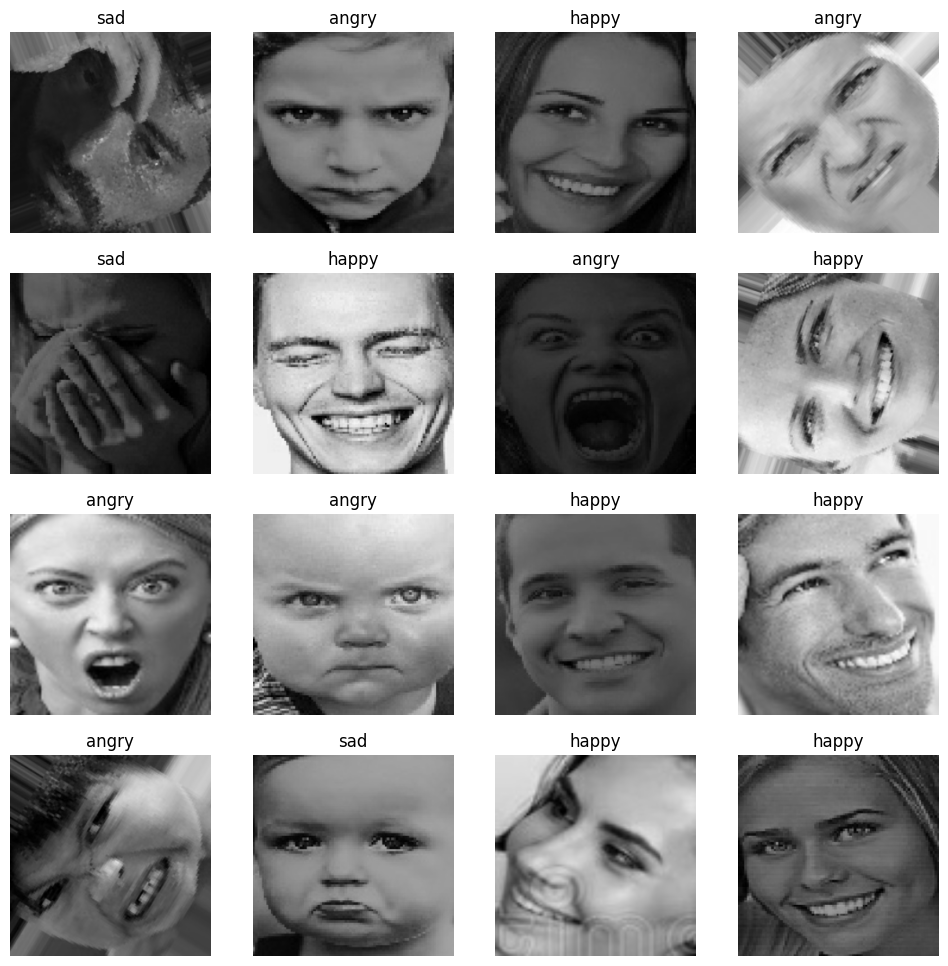

In [12]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(CLASS_NAMES[label_index])
    # plt.title((tf.argmax(labels[i])).numpy()) printing when printing the index value of classes when using bianry vector mode
    ax.axis('off')

# Data Augmentation



In [55]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025, 0.025)), # rotation is limited
    RandomFlip(mode= 'horizontal'),
    RandomContrast(factor= 0.1)

])

In [56]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

## Cutmix augmentation

In [57]:
def box(lamda):
  # lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  # lamda = lamda.sample(1)[0]

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, CONFIGURATION['IM_SIZE']) # this method_makes sure that the value stays only between 0, IM_SIZE not negative

  x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, CONFIGURATION['IM_SIZE']) # x_b_r is x bottom right and clip is to make the sure value is always inside the image bounds

  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [58]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2) # generates random values based on probabilites and proportions
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda) # calling the function that creats random box in the image

  crop_1 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  crop_2 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  image = image_1 - pad_2 + pad_1

  # for label
  lamda = tf.cast(1 - (r_w * r_h) / (CONFIGURATION['IM_SIZE'] * CONFIGURATION['IM_SIZE']) , dtype= tf.float32)
  label = lamda* tf.cast(label_1, dtype = tf.float32) + (1-lamda)* tf.cast(label_2, dtype = tf.float32)

  return image, label

In [59]:
# data preparation for cutmix
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls= tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [60]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

# Dataset Preparation

In [61]:
# training_dataset = (
#     train_dataset
#     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )
# using cutmix thats why in comments

In [62]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [63]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
]) # its good for deployment and prevents extra steps

# Modeling

## Transfer Learning with EfficientNet

In [64]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False, # we are not training or fine-tuning the top part/ feature extractor part
    weights='imagenet',
    input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

In [65]:
# specifying the weights in the upper part to be untrainable as we will levergaing those weights, freezing our model
backbone.trainable = False # crucial step

In [66]:
# finetuning the last layers to fit the cause of the emotion dataset

from keras.layers import GlobalAveragePooling2D, Dense
from keras.api._v2.keras.layers import Input
model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    GlobalAveragePooling2D(),

    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    BatchNormalization(),

    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu'),

    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax'),
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               131200    
                                                                 
 dense_8 (Dense)             (None, 3)                

## Finetuning EfficientNet

In [ ]:
backbone.trainable = True # updating the weights

In [74]:
from keras.models import Model
input =  Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3))
x = backbone(input, training = False) # not allowing it to use the same mean and variance used for training
x = GlobalAveragePooling2D()(x)


x = Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)

output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'relu')(x)

fine_tuned_model = Model(input, output)


ValueError: ignored

# Training

In [67]:
# from keras.callbacks import ModelCheckpoint


# checkpoint_callback = ModelCheckpoint(
#     'best_weights', monitor='val_accuracy', mode= 'max', verbose= 1, save_best_only= True
# )

In [68]:
# when the dataset is in vector mode or categorical mode [0, 1, 0] belongs to class 2 for instance
loss_function = CategoricalCrossentropy()
# incase our dataset mode is int where labels are [0, 1, 2]then we use:
# loss_function = SparseCategoricalCrossentropy()

In [69]:
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]


In [81]:
model.compile(
    optimizer =  tf.keras.optimizers.legacy.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/ 100),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,

)

Epoch 1/20
213/213 [==============================] - 72s 270ms/step - loss: 0.5980 - accuracy: 0.8087 - top_k_accuracy: 0.9477 - val_loss: 0.4576 - val_accuracy: 0.8314 - val_top_k_accuracy: 0.9399
Epoch 2/20
213/213 [==============================] - 55s 253ms/step - loss: 0.5923 - accuracy: 0.8081 - top_k_accuracy: 0.9412 - val_loss: 0.4721 - val_accuracy: 0.8327 - val_top_k_accuracy: 0.9412
Epoch 3/20
213/213 [==============================] - 55s 253ms/step - loss: 0.6028 - accuracy: 0.7998 - top_k_accuracy: 0.9431 - val_loss: 0.4644 - val_accuracy: 0.8253 - val_top_k_accuracy: 0.9407
Epoch 4/20
213/213 [==============================] - 55s 252ms/step - loss: 0.5944 - accuracy: 0.8006 - top_k_accuracy: 0.9471 - val_loss: 0.4629 - val_accuracy: 0.8257 - val_top_k_accuracy: 0.9403
Epoch 5/20
213/213 [==============================] - 55s 253ms/step - loss: 0.6103 - accuracy: 0.7936 - top_k_accuracy: 0.9382 - val_loss: 0.4617 - val_accuracy: 0.8253 - val_top_k_accuracy: 0.9390
Epoch

# Model loss and accuracy Visualization

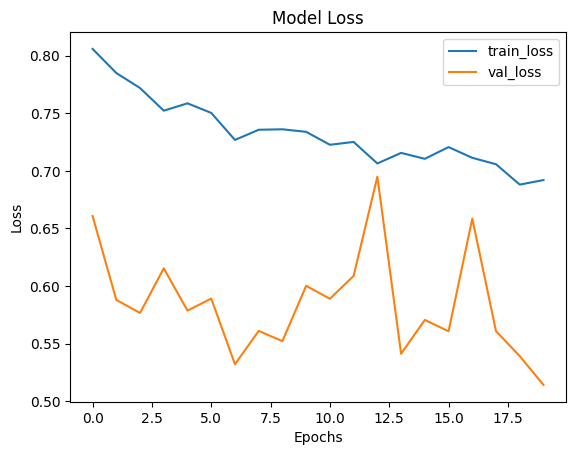

In [75]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

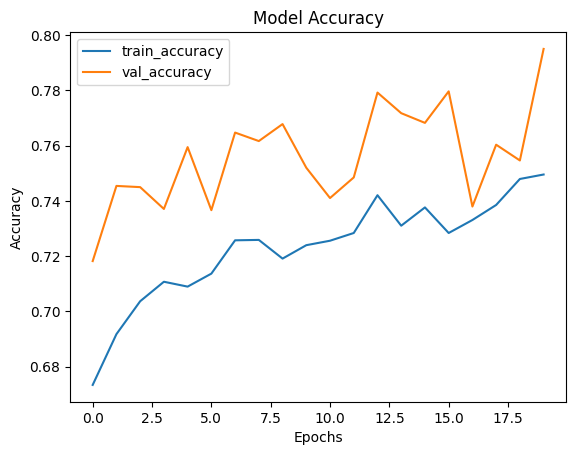

In [76]:
# the accuracy is low due to less epoch as compared to before which was trained for 60 epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [ ]:
model.evaluate(validation_dataset)

72/72 [==============================] - 4s 59ms/step - loss: 0.4317 - accuracy: 0.8472 - top_k_accuracy: 0.9530


[0.43172356486320496, 0.8472344279289246, 0.9530289769172668]

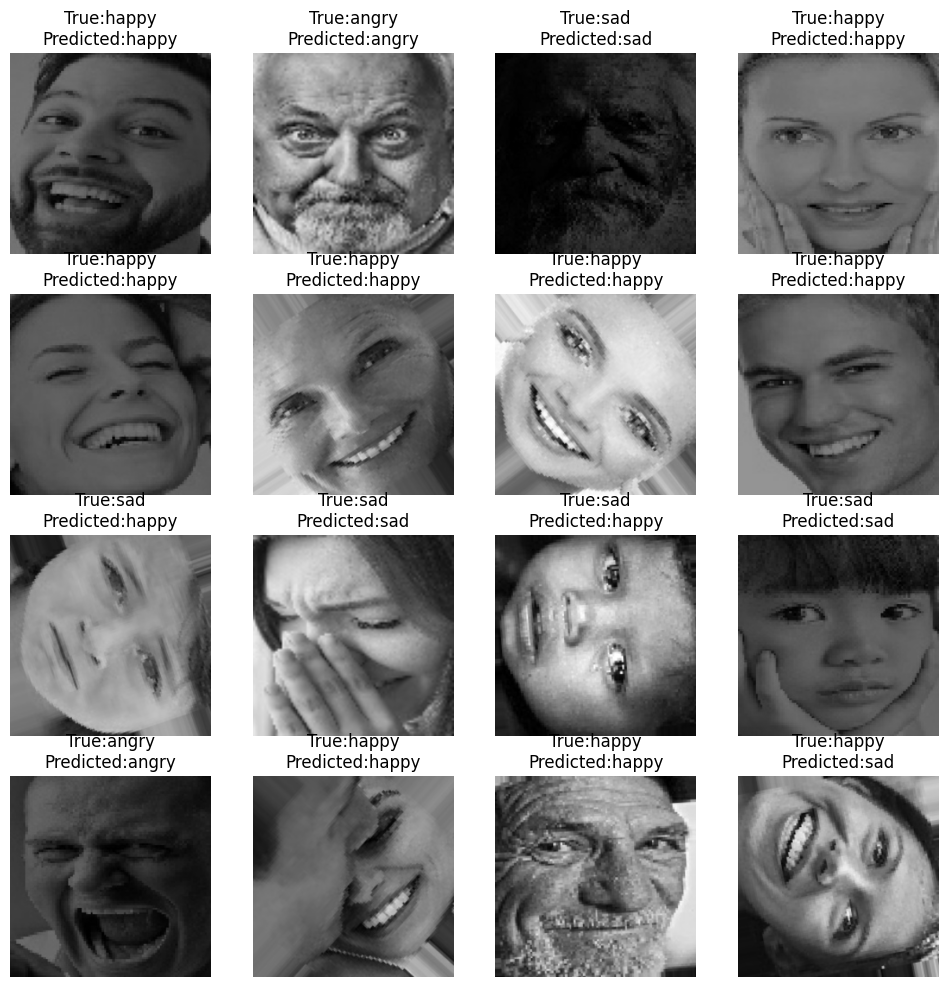

In [ ]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    predicted_index = tf.argmax(model(tf.expand_dims(images[i], axis = 0)).numpy()[0])
    plt.title('True:' + CLASS_NAMES[label_index] + '\n' + 'Predicted:' + CLASS_NAMES[predicted_index])
    ax.axis('off')

In [ ]:
13/16 # accuracy rate

0.8125

# Testing

In [ ]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

# converting image to tensor
image = tf.constant(test_image, dtype = tf.float32)

# expanding dimensions or batching
image = tf.expand_dims(image, axis = 0) # axis = 0 means adding dimesion along the front for instance: (224, 224, 3) -> (0, 224, 224, 3) batched tensor

print(CLASS_NAMES[tf.argmax(model(image), axis = -1).numpy()[0]]) # printing alongwith class since our dataset was preset with vector mode

happy


# Confusion matrix

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(model(im))
    labels.append(label.numpy())


In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[2 1 2 ... 0 2 0]
[2 1 2 ... 2 2 0]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
label = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[371  49  95]
 [ 20 919  67]
 [ 39  59 659]]


Text(0.5, 58.7222222222222, 'Predicted')

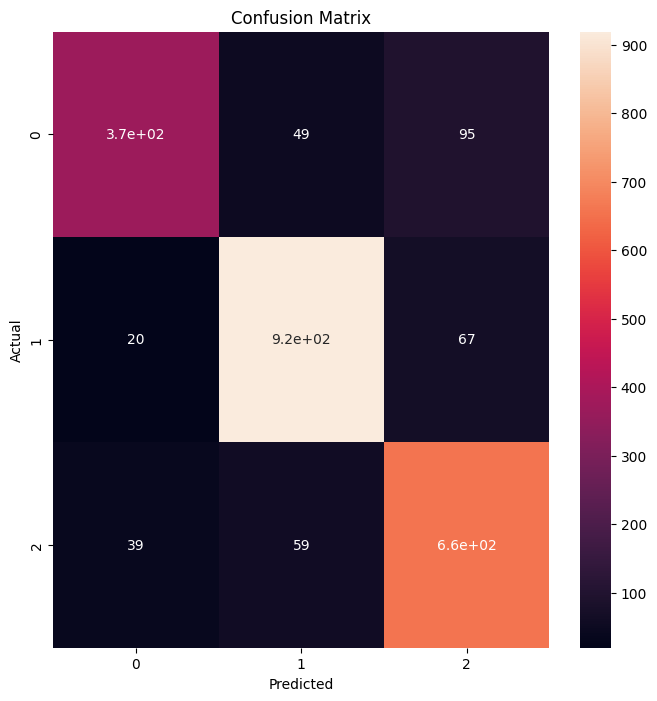

In [ ]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')